In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import plotly.express as px
from geopy.geocoders import Nominatim
import folium

In [2]:
from notebook.services.config import ConfigManager
ConfigManager().update('notebook', {'limit_output': 3_000_000});

In [3]:
df = pd.read_csv("./data/train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


<AxesSubplot:xlabel='target', ylabel='count'>

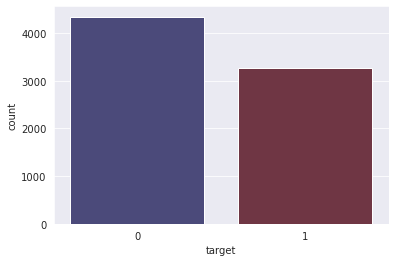

In [6]:
sns.set_style('darkgrid')
sns.countplot(x='target', data=df, palette='icefire')

In [9]:
df_locations_cat = df.groupby(['location', 'target'])[['id']].count().sort_values(by='id', ascending=False)
df_locations_cat

,,id
location,target,
USA,1,67
New York,0,55
USA,0,37
London,0,29
United States,1,27
...,...,...
"Huntsville, Alabama",1,1
Hustletown,1,1
Hyderabad Telangana INDIA,1,1


In [10]:
df_locations_total = df_locations_cat.groupby('location').sum().sort_values(by='id', ascending=False)
df_locations_total

,id
location,
USA,104
New York,71
United States,50
London,45
Canada,29
...,...
Hueco Mundo,1
"Hughes, AR",1
"Huntington, WV",1


In [11]:
def find_long_lat(name: str) -> tuple[int, int]:
    geolocator = Nominatim(user_agent='user_agent')
    location = geolocator.geocode(name)
    if location:
        return location.longitude, location.latitude
    return 0, 0

In [12]:
df_locations_total = df_locations_total.iloc[:100]
df_locations_total

,id
location,
USA,104
New York,71
United States,50
London,45
Canada,29
...,...
North Carolina,5
Philippines,5
"Cleveland, OH",5


In [13]:
df_locations_total['long'] = df_locations_total \
                            .index              \
                            .to_series()        \
                            .apply(lambda x: find_long_lat(x)[0])
df_locations_total['lat'] = df_locations_total  \
                            .index              \
                            .to_series()        \
                            .apply(lambda x: find_long_lat(x)[1])

df_locations_total

/tmp/ipykernel_51803/525042958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_locations_total['long'] = df_locations_total \
/tmp/ipykernel_51803/525042958.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_locations_total['lat'] = df_locations_total  \


,id,long,lat
location,,,
USA,104,-100.445882,39.783730
New York,71,-74.006015,40.712728
United States,50,-100.445882,39.783730
London,45,-0.127647,51.507322
Canada,29,-107.991707,61.066692
...,...,...,...
North Carolina,5,-79.039292,35.672964
Philippines,5,122.731210,12.750349
"Cleveland, OH",5,-81.693681,41.499656


In [14]:
map_ = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)
# add marker one by one on the map
for i in range(0,len(df_locations_total)):
    folium.Circle(
      location=[df_locations_total.iloc[i]['lat'], df_locations_total.iloc[i]['long']],
      popup=f"{df_locations_total.index[i]}:{df_locations_total.iloc[i]['id']}",
      radius=float(df_locations_total.iloc[i]['id'])*20000,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(map_)

map_

,location,target,id
0,USA,1,67
1,New York,0,55
2,USA,0,37
3,London,0,29
4,United States,1,27
...,...,...,...
3650,"Huntsville, Alabama",1,1
3651,Hustletown,1,1
3652,Hyderabad Telangana INDIA,1,1
3653,Hyrule,0,1


In [24]:
df_loc_cat_new = df_locations_cat.reset_index()
df_loc_cat_new['target_str'] = df_loc_cat_new['target'].apply(lambda x: 'Disaster' if x == 1 else 'Not disaster')
fig = px.bar(df_loc_cat_new[:50], x='location', y='id', color='target_str')
fig.update_layout(
    title='class count per country',
    xaxis_title='Location', 
    yaxis_title = 'Counts', 
)